## Introduction

### Background
Data scientists and machine learning professionals have a responsibility to ensure that the machine learning models we build and deploy are as free from unwanted bias as possible. 

This is a very challenging problem for machine learning as a discipline. Conceptually, definitions of unwanted bias are highly contested and contradictory. Practically, many forms of unwanted bias within our models are so deeply enmeshed in society that entire popular movements are needed to fully address them.

A basic component of bias auditing is understanding the behaviour of a machine learning model with respect to a protected class, such as race, gender, religion and so on. Yet even these basic assessments of bias along protected class lines are usually challenged by the fact that granular protected class information is not available within the data.

### What this package does 

The purpose of this package is to allow for assessment of various bias metrics along protected class lines where the protected class information is not available for the data, in a binary classification context. For a given bias metric, this package provides partial identification sets. These sets contain *all possible* values for a bias metric, subject to the weak assumptions made within https://arxiv.org/pdf/1906.00285.pdf.

This package is based around the Cellophane class, which takes two datasets as input:
 - a primary dataset, which contains features, ground truth, and model predictions. This could be a dataset which you use to train or validate the model when building it.
 - a auxiliary dataset, which contains protected class information, and some features which overlap with the primary set (called proxies). This dataset will not contain ground truth or model predictions. For instance, this dataset could be an excerpt of the census which contains demographic information by region.

Typically the stronger the predictive power of the proxy column, the smaller the partial identification sets will be, reflecting
increased certainty.

# Imports

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from cellophane import Cellophane
import cellophane.utils as utils

# Load data and train initial models

In [2]:
#Load primary dataset
primary = pd.read_csv('data/warfarin/primary.csv')

#Train model to predict target variable
X_cols = list(set(primary.columns).difference(('race', 'target', 'therapeut_dose')))
np.random.seed(42)
base_rfc = RandomForestRegressor()
base_rfc.fit(primary[X_cols], primary['therapeut_dose'])
primary['target'] = primary['therapeut_dose'] > 35
primary['prediction'] = base_rfc.predict(primary[X_cols]) > 35 

#Define proxy columns (found in primary and auxiliary dataset)
proxy_cols = ['VKORC1..4451.', 'VKORC1.2255.', 'VKORC1.3730.', 'VKORC1.1542.', 'VKORC1.1173.', 'VKORC1.497.', 'VKORC1..1639.', 'Acetaminophen.', 'Acetaminophen.hi.dose.', 'Simvastatin.', 'Atorvastatin.', 'Fluvastatin.', 'Lovastatin.', 'Pravastatin.', 'Rosuvastatin.', 'Cerivastatin.', 'Amiodarone.', 'Carbamazepine.', 'Phenytoin.', 'Rifampin.', 'Sulfonamide.Antibiotics.', 'Macrolide.Antibiotics.', 'Anti.fungal.Azoles.', 'Herbal.Medications..Vitamins..Supplements.']

#Read auxiliary dataset, selecting proxy columns and protected class information
auxiliary = pd.read_csv('data/warfarin/auxiliary.csv')[proxy_cols+['race']]

# Initialize cellophane class to audit sample dataset and model

In [3]:
warfarin_audit = Cellophane(primary, #primary dataset, containing training or testing data but no protected class information
                auxiliary, #auxiliary dataset, with some columns overlapping the primary dataset (proxy columns) and protected class information
                X_cols, #columns used for training. Should be found in the primary dataset
                proxy_cols, #proxy columns. Should be found in both primary and secondary datasets
                'target', #name of ground truth column. Should be found in the primary dataset.
                'race', #name of protected class column. Should be found in the secondary dataset.
                'prediction', #name of model's prediction column. Should be found in the primary dataset
                          )

# Calculate set of all possible true positive rates for White protected class

In [4]:
warfarin_audit.tpr_reading('White')

{'lower_bound': 0.9053030303030304,
 'expected_value': 0.9552980132450332,
 'upper_bound': 1.0}

# Calculate set of all possible true positive rates for Asian protected class

In [5]:
warfarin_audit.tpr_reading('Asian')

{'lower_bound': 0.0, 'expected_value': 0.8208955223880597, 'upper_bound': 1.0}

# Calculate set of all possible true positive rate disparities between White protected class and all others

In [6]:
warfarin_audit.tpr_disparity('White')

{'lower_bound': -0.09469696969696961,
 'expected_value': 0.01190178682993881,
 'upper_bound': 0.8777777777777778}

# Calculate set of all possible true positive rate disparities between African-American and White protected classes

In [7]:
warfarin_audit.tpr_disparity('Black','White')

{'lower_bound': -1.0,
 'expected_value': 0.04470198675496684,
 'upper_bound': 0.09469696969696961}

# Plot set of possible outcomes for most bias metrics

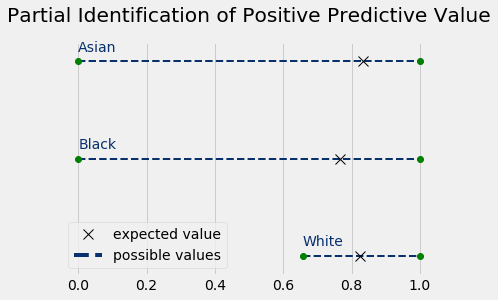

In [8]:
title = 'Partial Identification of Positive Predictive Value'
protected_class_names = ['White','Black','Asian']
intervals = [warfarin_audit.ppv_reading(protected_class) for protected_class in protected_class_names]
fig = utils.plot_intervals(title, protected_class_names, intervals)

# Plot set of possible outcomes for most disparities in bias metrics

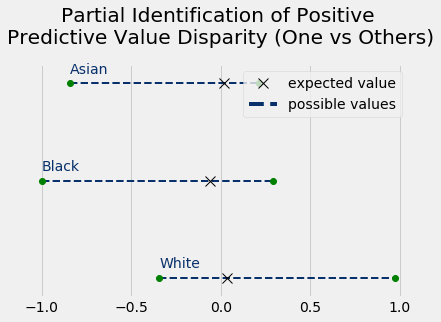

In [9]:
title = 'Partial Identification of Positive \nPredictive Value Disparity (One vs Others)'
protected_class_names = ['White','Black','Asian']
intervals = [warfarin_audit.ppv_disparity(protected_class) for protected_class in protected_class_names]
fig = utils.plot_intervals(title, protected_class_names, intervals, lower_limit=-1)